In [ ]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, random_split

from src.methods.rise_model import RISE
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

from src.common.utils import *
from src.common.evaluation import CausalMetric, auc, gkern

import zipfile
from pathlib import Path

In [ ]:
# --- SET SEED FOR REPRODUCIBILITY ---
SEED = 42  # фиксируем seed для полной воспроизводимости
torch.manual_seed(SEED)  # фиксируем seed для PyTorch
random.seed(SEED)        # фиксируем seed для Python random
np.random.seed(SEED)     # фиксируем seed для NumPy
torch.backends.cudnn.deterministic = True  # гарантирует детерминированность на GPU
torch.backends.cudnn.benchmark = False     # отключаем autotuner, чтобы не влиял на детерминированность

# --- CONFIGURATION ---
unzip_dir = 'unzipped_data_full'

zip_path = os.path.abspath("../data_full.zip")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

data_dir = 'unzipped_data_full/data_full'
batch_size = 8                 # количество изображений в одном батче
num_epochs = 20                # сколько раз модель проходит весь датасет
val_split = 0.2                # доля валидационных данных (20%)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # автоматический выбор CUDA или CPU
device

device(type='cuda')

In [3]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [4]:
# трансформации для валидационной выборки (без аугментаций)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# --- DATASET ---
full_dataset = datasets.ImageFolder(data_dir)   # читаем датасет: каждая папка = один класс
class_names = full_dataset.classes              # сохраняем список классов

val_size = int(len(full_dataset) * val_split)   # размер валидационной выборки
train_size = len(full_dataset) - val_size       # размер тренировочной выборки

# фиксированный random_split с генератором (для стабильного train/val деления)
generator = torch.Generator().manual_seed(SEED)
_, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

# применяем трансформации
val_dataset.dataset.transform = val_transform

In [ ]:
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))

model.load_state_dict(torch.load('../best_model.pth'))
model = model.eval()
model = model.to(device)

for p in model.parameters():
    p.requires_grad = False

In [6]:
def generate_masks_by_method(explainer, method, savepath='masks.npy'):
    if method == 'binary p 0.1':
        explainer.generate_masks(N=6000, s=8, p1=0.1, savepath=savepath)
    elif method == 'binary p 0.3':
        explainer.generate_masks(N=6000, s=8, p1=0.3, savepath=savepath)
    elif method == 'binary p 0.5':
        explainer.generate_masks(N=6000, s=8, p1=0.3, savepath=savepath)
    elif method == 'binary p 0.7':
        explainer.generate_masks(N=6000, s=8, p1=0.3, savepath=savepath)
    
    elif method == 'gaussian_8':
        explainer.generate_gaussian_masks(N=6000, s=8, savepath=savepath)
    elif method == 'gaussian_28':
        explainer.generate_gaussian_masks(N=6000, s=28, savepath=savepath)
    elif method == 'gaussian_56':
        explainer.generate_gaussian_masks(N=6000, s=56, savepath=savepath)
    elif method == 'gaussian_112':
        explainer.generate_gaussian_masks(N=6000, s=112, savepath=savepath)
    elif method == 'gaussian_224':
        explainer.generate_gaussian_masks(N=6000, s=224, savepath=savepath)
    


    elif method == 'perlin':
        explainer.generate_perlin_masks(N=6000, s=8, savepath=savepath)
    else:
        raise ValueError(f"Unknown method: {method}")

In [7]:
explainer = RISE(model, input_size=(224, 224), gpu_batch=250)
# methods = ['gaussian_8', 'gaussian_28', 'gaussian_56', 'gaussian_112', 'gaussian_224']
methods = ['gaussian_8', 'gaussian_112', 'gaussian_224']

=== Метод: gaussian_8 ===


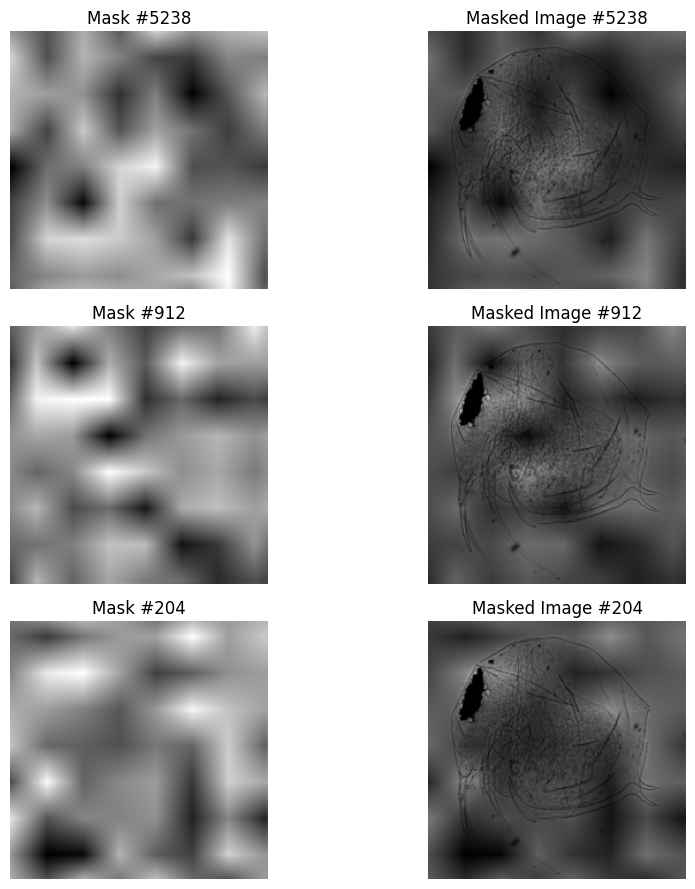

=== Метод: gaussian_112 ===


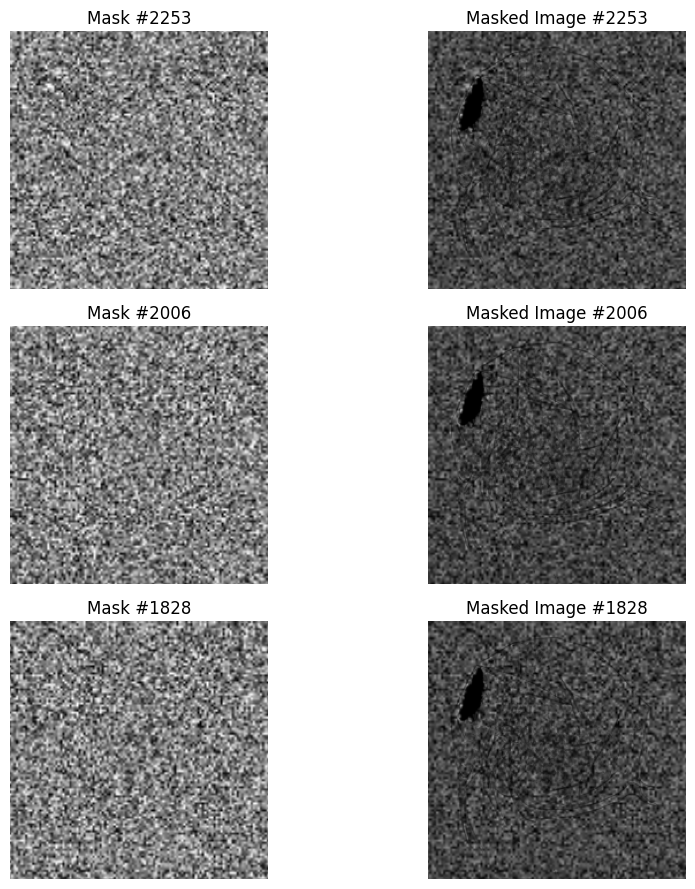

=== Метод: gaussian_224 ===


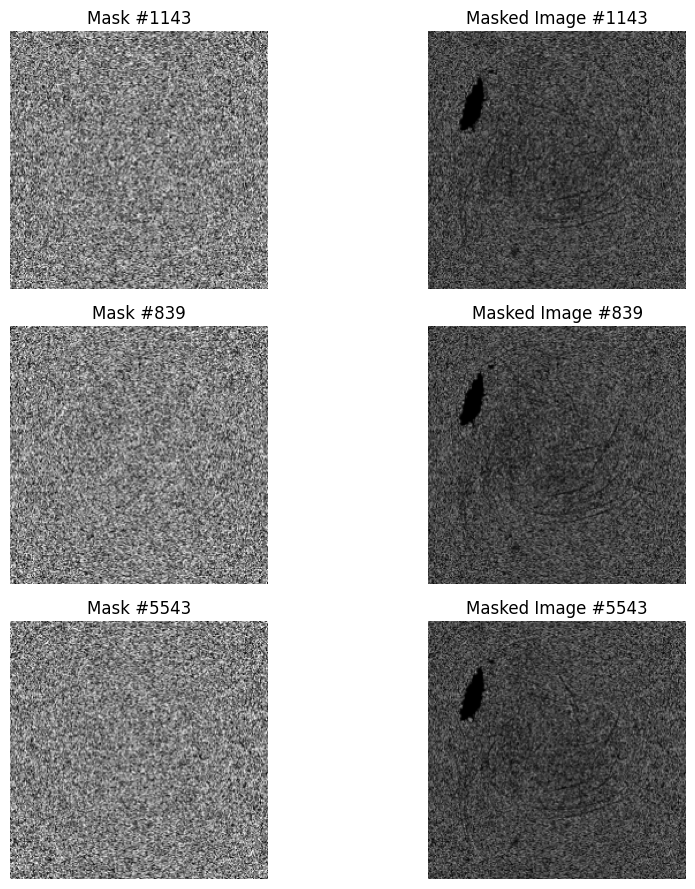

In [8]:
for method in methods:
    print(f"=== Метод: {method} ===")
    save_path = f"masks_{method.replace(' ', '_')}.npy"
    
    generate_masks_by_method(explainer, method, savepath=save_path)
    explainer.load_masks(save_path)
    
    sample_img, label = val_dataset[0]
    sample_img = sample_img.unsqueeze(0).to(device)

    visualize_masks_and_masked_images(sample_img, explainer.masks, num=3)

In [9]:
def explain_and_plot(img, class_names=None, top_k=1):
    saliency = explainer(img.cuda()).cpu().numpy()

    output = model(img)
    probs = torch.softmax(output, dim=1)
    p, c = torch.topk(probs, k=top_k)
    p, c = p[0], c[0]

    plt.figure(figsize=(10, 5 * top_k))
    for i in range(top_k):
        plt.subplot(top_k, 2, 2 * i + 1)
        plt.axis('off')
        class_name = class_names[c[i]]
        title = f'{100 * p[i]:.1f}% {class_name}'
        plt.title(title)
        tensor_imshow(img[0])

        plt.subplot(top_k, 2, 2 * i + 2)
        plt.axis('off')
        plt.title('Saliency')
        tensor_imshow(img[0])
        plt.imshow(saliency[c[i]], cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# sample_img, label = val_dataset[0]
# sample_img = sample_img.unsqueeze(0).to(device) 
# explain_and_plot(sample_img, class_names=class_names)

=== Метод: gaussian_8 ===


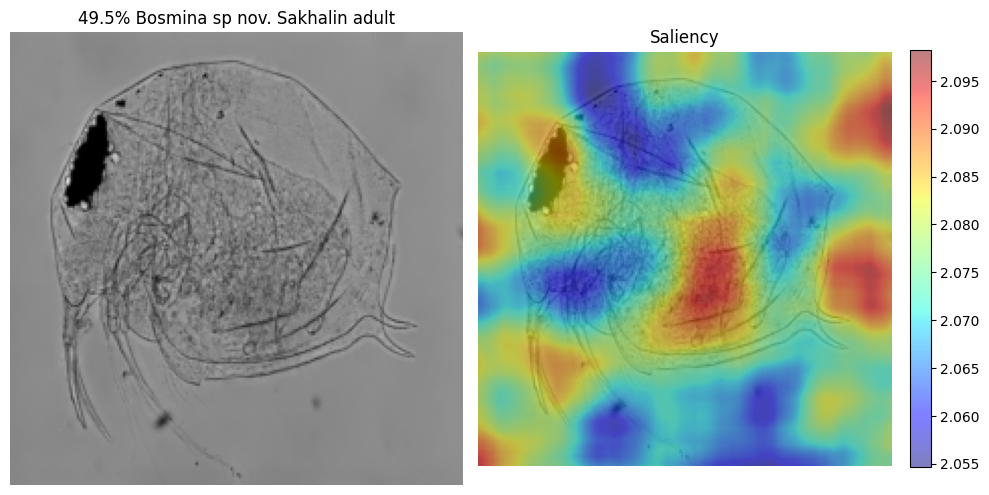

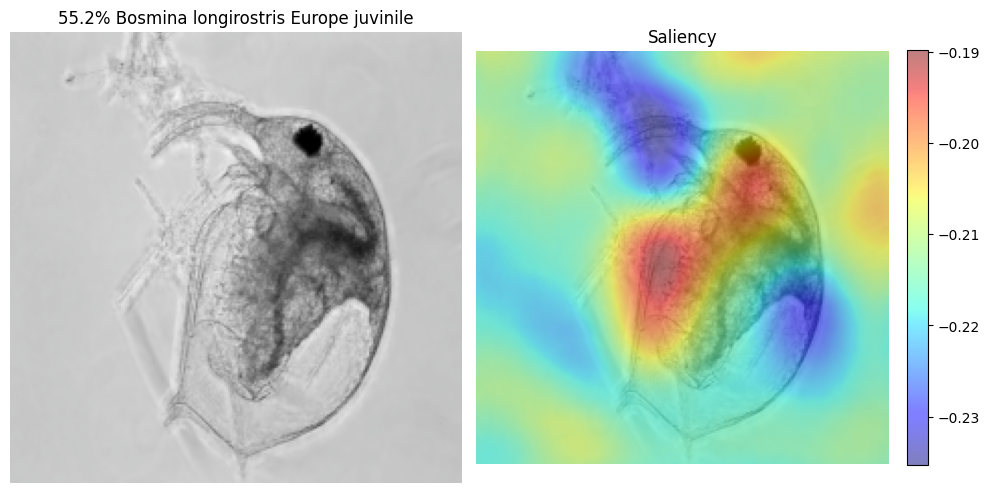


=== Метод: gaussian_112 ===


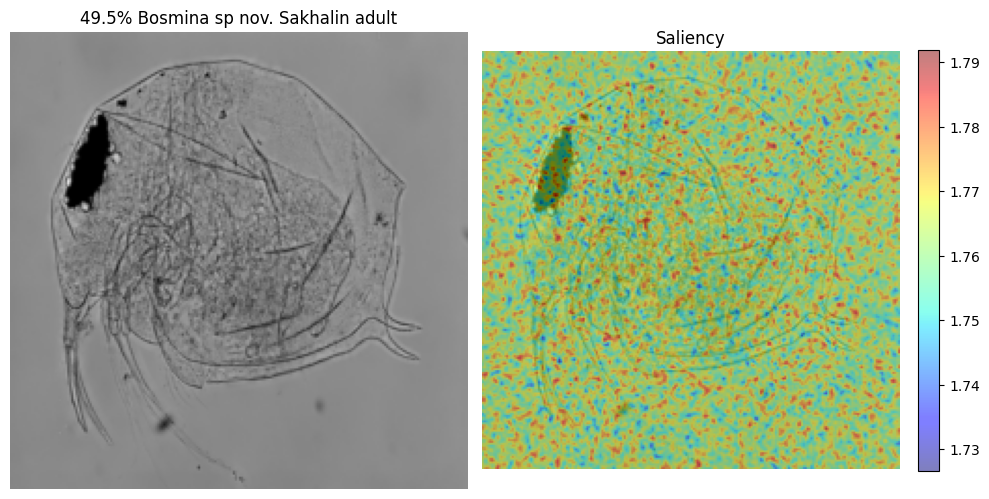

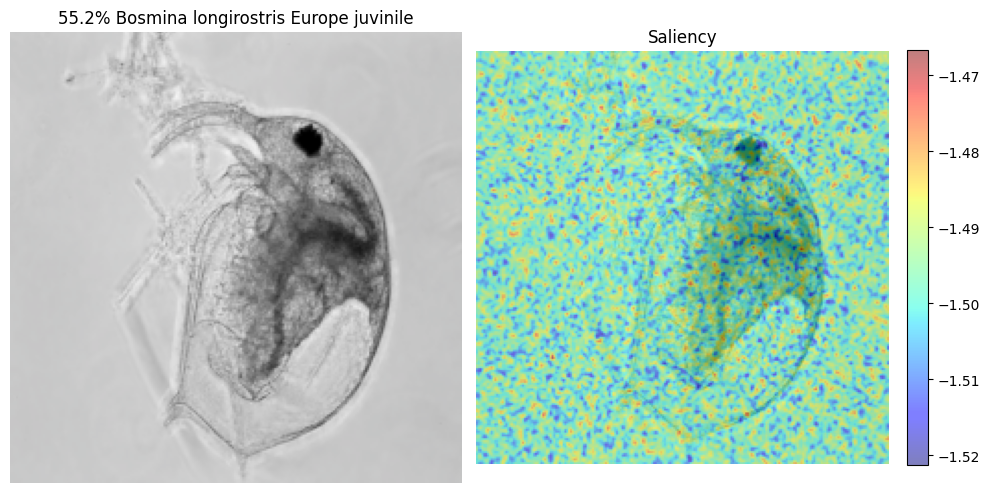


=== Метод: gaussian_224 ===


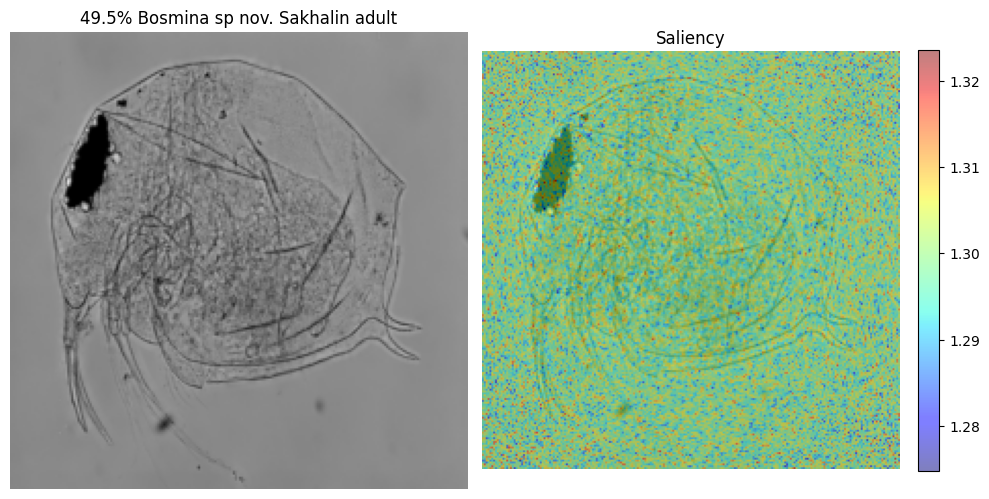

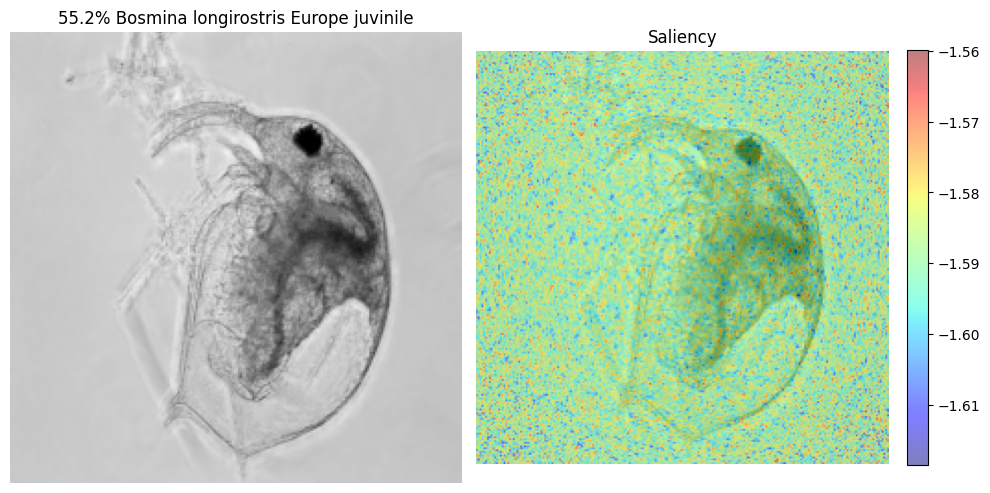

In [10]:
for method in methods:
    print(f"=== Метод: {method} ===")
    save_path = f"masks_{method.replace(' ', '_')}.npy"
    explainer.load_masks(save_path)
    
    sample_img, label = val_dataset[0]
    sample_img = sample_img.unsqueeze(0).to(device)
    explain_and_plot(sample_img, class_names=class_names)

    sample_img, label = val_dataset[8]
    sample_img = sample_img.unsqueeze(0).to(device)
    explain_and_plot(sample_img, class_names=class_names)
    print()

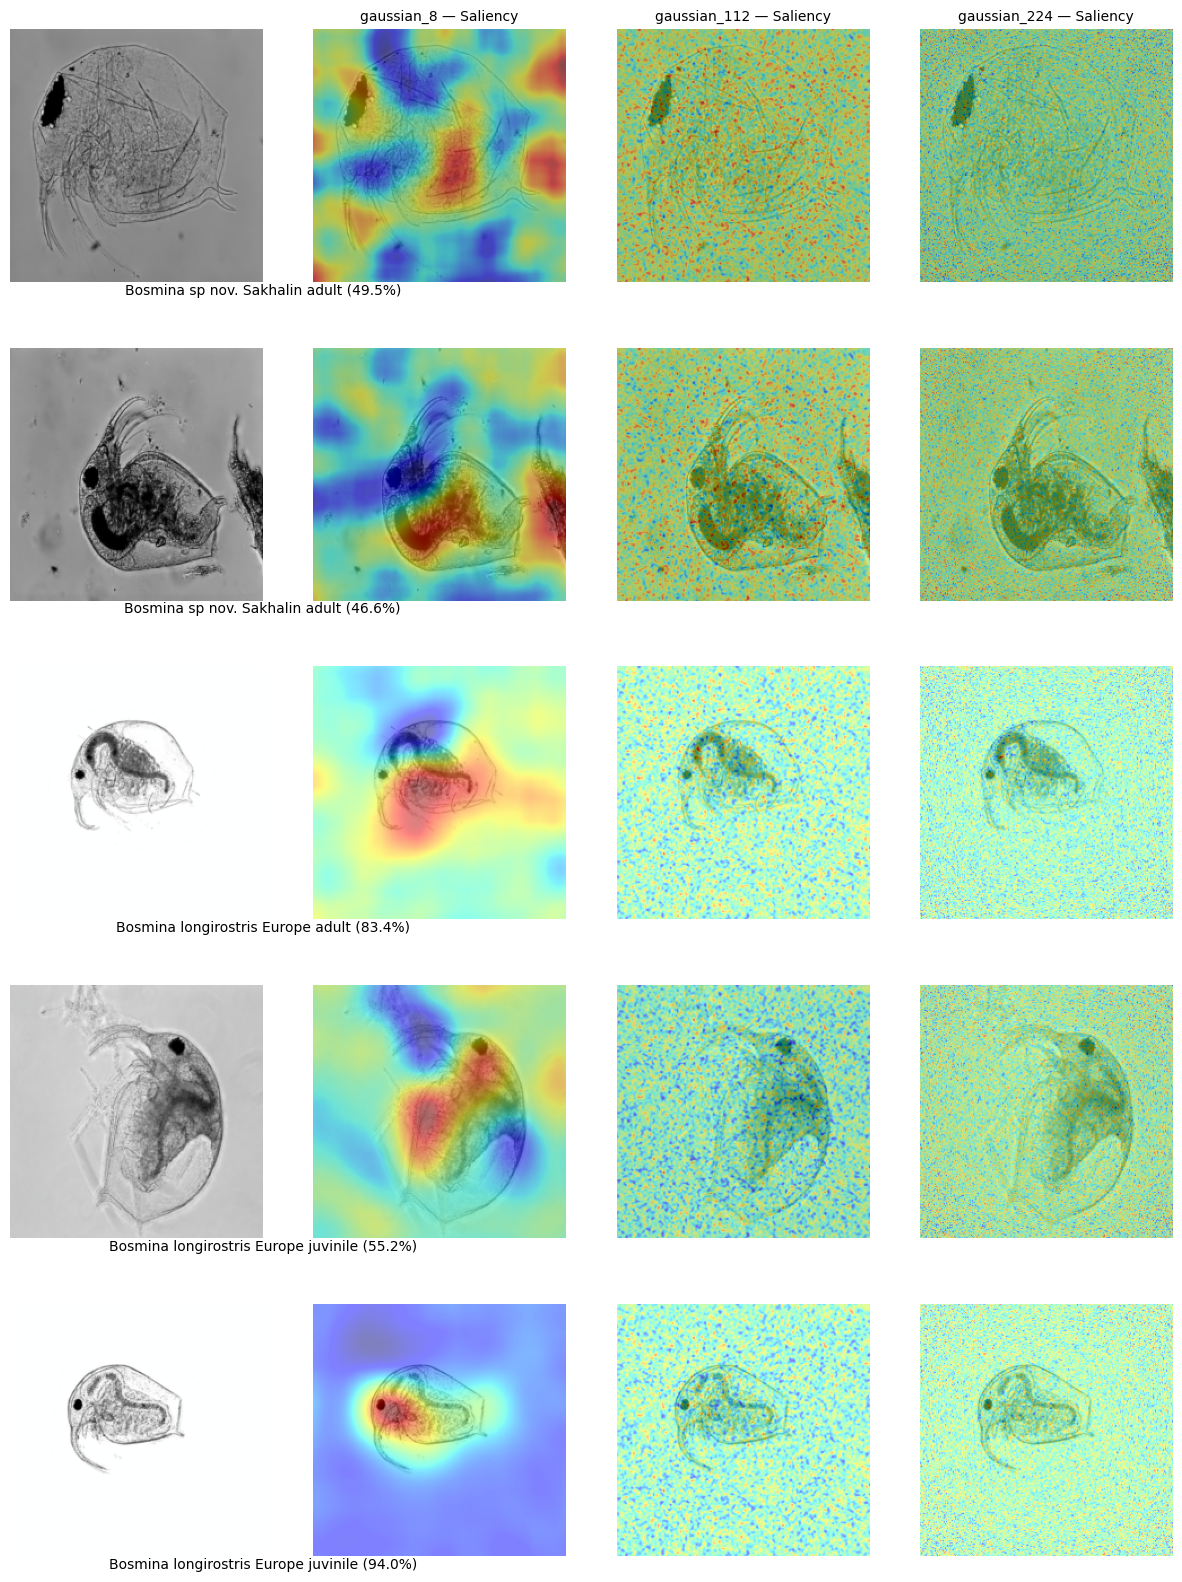

In [11]:
def compare_rise_methods(methods, indices=None):
    if indices is None:
        indices = [0, 4, 6, 8, 9]
    n_samples = len(indices)
    n_methods = len(methods)

    fig, axes = plt.subplots(n_samples, n_methods + 1, figsize=(2.5 * n_methods * 2, 4 * n_samples))

    for method_idx, method in enumerate(methods):
        savepath = f'masks_{method.replace(" ", "_")}.npy'
        explainer.load_masks(savepath)

        for row_idx, idx in enumerate(indices):
            img, label = val_dataset[idx]
            img_input = img.unsqueeze(0).to(device)

            saliency = explainer(img_input.cuda()).cpu().numpy()

            with torch.no_grad():
                output = model(img_input)
                probs = torch.softmax(output, dim=1)
                conf, class_idx = torch.max(probs, dim=1)

            class_name = class_names[class_idx.item()]
            prob_text = f"{class_name} ({100 * conf.item():.1f}%)"

            # Original image
            if method_idx == 0:
                ax_orig = axes[row_idx, method_idx * 2]
                ax_orig.axis('off')
                tensor_imshow(img.cpu(), ax=ax_orig)
            # if row_idx == 0:
            #     ax_orig.set_title(f"{method} — Original", fontsize=12)
            if method_idx == 0:
                ax_orig.text(1, -0.05, prob_text, fontsize=10, ha='center', transform=ax_orig.transAxes)

            # Saliency map
            ax_sal = axes[row_idx, method_idx + 1]
            ax_sal.axis('off')
            tensor_imshow(img.cpu(), ax=ax_sal)
            ax_sal.imshow(saliency[class_idx.item()], cmap='jet', alpha=0.5)
            if row_idx == 0:
                ax_sal.set_title(f"{method} — Saliency", fontsize=10)
        
    # plt.tight_layout()
    plt.show()

compare_rise_methods(methods)

In [12]:
# def compare_rise_methods_by_rows(methods, indices=None):
#     if indices is None:
#         indices = [0, 4, 6, 8, 9]
#     n_samples = len(indices)
#     n_methods = len(methods)

#     fig, axes = plt.subplots(n_methods, n_samples * 2, figsize=(2.5 * n_samples * 3, 4 * n_methods))

#     for method_idx, method in enumerate(methods):
#         savepath = f'masks_{method.replace(" ", "_")}.npy'
#         explainer.load_masks(savepath)

#         for sample_idx, idx in enumerate(indices):
#             img, label = val_dataset[idx]
#             img_input = img.unsqueeze(0).to(device)

#             saliency = explainer(img_input).cpu().numpy()

#             with torch.no_grad():
#                 output = model(img_input)
#                 probs = torch.softmax(output, dim=1)
#                 conf, class_idx = torch.max(probs, dim=1)

#             class_name = class_names[class_idx.item()]
#             prob_text = f"{class_name} ({100 * conf.item():.1f}%)"

#             # Original image
#             ax_orig = axes[method_idx, sample_idx * 2]
#             ax_orig.axis('off')
#             tensor_imshow(img.cpu(), ax=ax_orig)
#             if method_idx == 0:
#                 ax_orig.set_title(f"Image {idx}", fontsize=10)

#             # Saliency map
#             ax_sal = axes[method_idx, sample_idx * 2 + 1]
#             ax_sal.axis('off')
#             tensor_imshow(img.cpu(), ax=ax_sal)
#             ax_sal.imshow(saliency[class_idx.item()], cmap='jet', alpha=0.5)

#             if method_idx == 0:
#                 ax_sal.set_title("Saliency", fontsize=10)
#                 ax_orig.text(1, -0.1, prob_text, fontsize=10, ha='center', transform=ax_orig.transAxes)
#             if sample_idx == 0:
#                 ax_orig.text(-0.05, 0.5, method, fontsize=12, ha='right', va='center', rotation=90, transform=ax_orig.transAxes)

#     #plt.tight_layout()
#     plt.show()

# compare_rise_methods_by_rows(methods, indices = [0, 4, 6])

In [13]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern.to(x.device), padding=klen//2)

In [14]:
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

=== Метод: gaussian_8 ===


Running deletion for gaussian_8


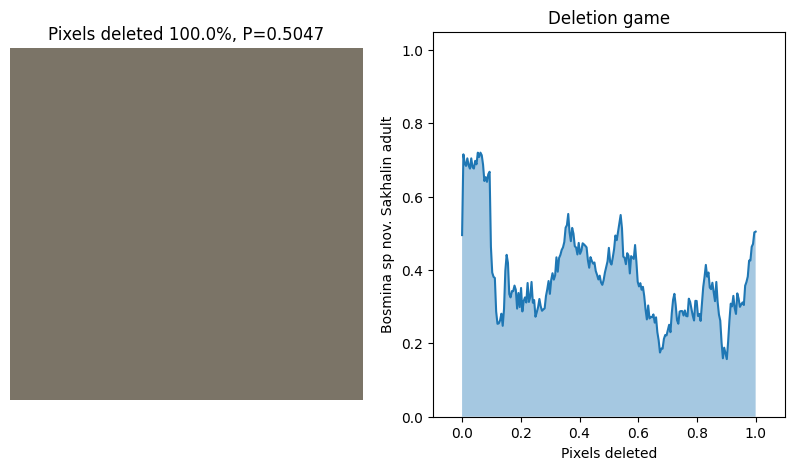

Running insertion for gaussian_8


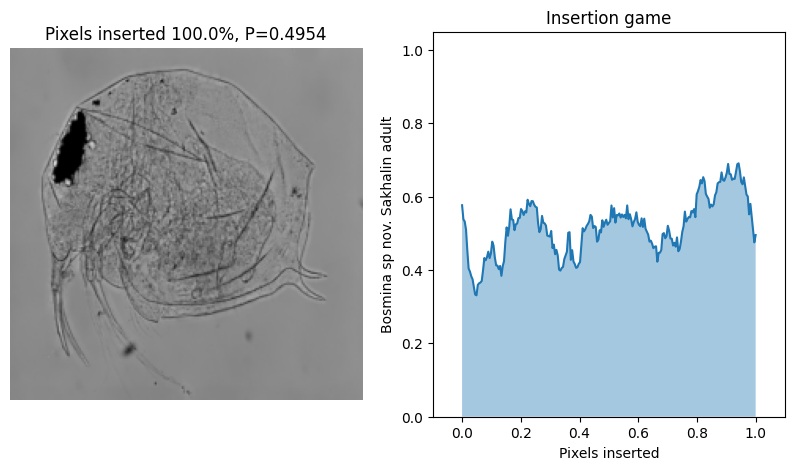


=== Метод: gaussian_112 ===


Running deletion for gaussian_112


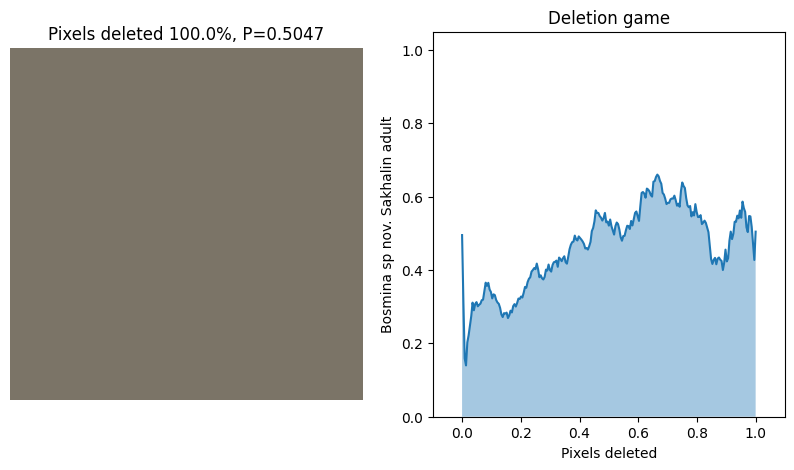

Running insertion for gaussian_112


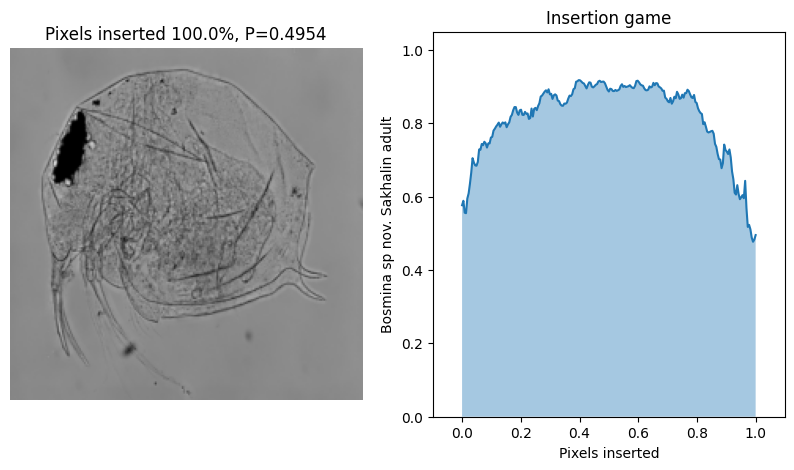


=== Метод: gaussian_224 ===


Running deletion for gaussian_224


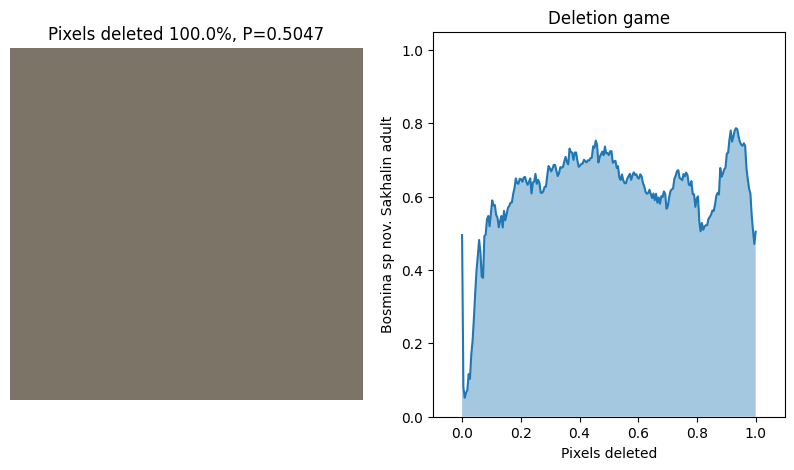

Running insertion for gaussian_224


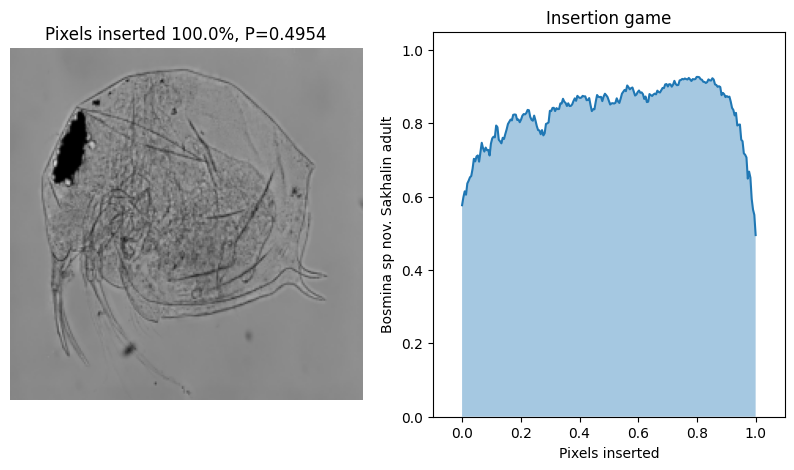

In [15]:
sample_img, _ = val_dataset[0]
sample_img = sample_img.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(sample_img)
    probs = torch.softmax(output, dim=1)
    top1_class = probs.argmax(dim=1).item()

    for method in methods:
        print(f"=== Метод: {method} ===")
        save_path = f"masks_{method.replace(' ', '_')}.npy"
        explainer.load_masks(save_path)
    
        saliency_all = explainer(sample_img).cpu().numpy()
        saliency = saliency_all[top1_class]

        print(f"Running deletion for {method}")
        deletion.single_run(sample_img, saliency, class_names=class_names,
                                device=device, verbose=1)

        print(f"Running insertion for {method}")
        insertion.single_run(sample_img, saliency, class_names=class_names,
                                    device=device, verbose=1)
        print()


In [16]:
results = {}

for method in methods:
    print(f"=== Метод: {method} ===")
    save_path = f"masks_{method.replace(' ', '_')}.npy"
    explainer.load_masks(save_path)

    images = []
    explanations = []

    for i in range(len(val_dataset)):
        img, _ = val_dataset[i]
        img = img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img)
            probs = torch.softmax(output, dim=1)
            top1_class = probs.argmax(dim=1).item()

        saliency_all = explainer(img).cpu().numpy()
        saliency = saliency_all[top1_class]

        images.append(img.squeeze(0).cpu())
        explanations.append(saliency)

    images_tensor = torch.stack(images).to(device)
    saliency_np = np.stack(explanations)

    insertion = CausalMetric(model, 'ins', step=224*8, substrate_fn=blur)
    deletion = CausalMetric(model, 'del', step=224*8, substrate_fn=torch.zeros_like)

    h_del = deletion.evaluate(images_tensor, saliency_np, device=device, batch_size=1)
    h_ins = insertion.evaluate(images_tensor, saliency_np, device=device, batch_size=1)

    auc_del = auc(h_del.mean(1))
    auc_ins = auc(h_ins.mean(1))

    results[method] = {"insertion_auc": auc_ins, "deletion_auc": auc_del}
    print(f"Deletion AUC: {auc_del:.4f}, Insertion AUC: {auc_ins:.4f}")


=== Метод: gaussian_8 ===


AUC: 0.27670858774580553


AUC: 0.5454106536228862
Deletion AUC: 0.2767, Insertion AUC: 0.5454
=== Метод: gaussian_112 ===


AUC: 0.27382044327453153


AUC: 0.5029850468565827
Deletion AUC: 0.2738, Insertion AUC: 0.5030
=== Метод: gaussian_224 ===


AUC: 0.3213464636740429


AUC: 0.5271884695491793
Deletion AUC: 0.3213, Insertion AUC: 0.5272


In [17]:
for method, scores in results.items():
    print(f"{method}: Deletion AUC = {scores['deletion_auc']:.4f}, Insertion AUC = {scores['insertion_auc']:.4f}")
    print()

gaussian_8: Deletion AUC = 0.2767, Insertion AUC = 0.5454

gaussian_112: Deletion AUC = 0.2738, Insertion AUC = 0.5030

gaussian_224: Deletion AUC = 0.3213, Insertion AUC = 0.5272

